In [1]:
import pandas as pd
import numpy as np
from scipy.integrate import dblquad
from math import *
import scipy.stats
from pandas import *
from scipy.integrate import quad
import seaborn as sns
import scipy as s
import warnings
warnings.filterwarnings("ignore")
from mpl_toolkits import mplot3d
import plotly.offline as pyoff
import plotly.graph_objs as go
import plotly.graph_objects as go
from scipy import linalg
pd.set_option('display.max_rows', 1000)
from tqdm.notebook import tqdm
import torch
import torch.nn as nn
from scipy.stats import norm
import matplotlib.pyplot as plt
from matplotlib import rc
from concurrent.futures import ProcessPoolExecutor
from scipy.special import kv
import time
import os

# Set data type
DTYPE='float32'

In [2]:
# The below is to load the Fredholm NN classes - Adjust according to your folder architecture/path where the fredholm_nn_models.py has been saved

from google.colab import drive
drive.mount('/content/drive')

FOLDER = "/content/drive/MyDrive/Fredholm_Neural_Networks/Github/Python"

import sys, os, importlib
if FOLDER not in sys.path:
    sys.path.insert(0, FOLDER)

# print("CWD:", os.getcwd())
# print("Folder exists?", os.path.isdir(FOLDER))
# print("Files:", os.listdir(FOLDER)[:10])


from potential_fredholm_nn_models import FredholmNeuralNetwork_Helm, PotentialFredholmNeuralNetwork_Helm


Mounted at /content/drive


# Functions and definitions used for the the Potential Fredholm Neural Network solution to the Helmholtz PDE.

We consider the two-dimensional linear Poisson equation for $u(x)$:

  \begin{equation}
        \begin{cases}\Delta u(x) - \lambda u(x) = \psi(x), & \text { for } x \in \Omega \\ u(x)= f(x) & \text { for } {x} \in \partial \Omega. \end{cases}
    \end{equation}




The Poisson PDE can be solved using a Fredholm NN, with $M+1$ hidden layers, where the weights and biases of the $M$ hidden layers are used iteratively solve the BIE (\ref{BIE}) on a discretized grid of the boundary, $y_1, \dots, y_N$,
for which the final and output weights $W_{M+1} \in \mathbb{R}^{N \times N}, W_O \in \mathbb{R}^N$ given by:
\begin{equation}
    W_{M+1}= I_{N \times N},
    \,\,\,\,\
    W_{O}= \left(\begin{array}{cccc}
	D \Phi({x}, {y}_1) \delta \sigma_{y}, & D \Phi({x}, {y}_2)\delta \sigma_{y}, & \dots, & {D} \Phi({x}, {y}_N) \delta \sigma_{y}
\end{array}\right)^{\top},
\end{equation}
are used to define the simple operator ${D} \Phi({x}, {y}):= \Big(\frac{\partial \Phi}{\partial n_{y}}({x}, {y})- \frac{\partial \Phi}{\partial n_{y}}({x}^{\star}, {y})\Big)$. The corresponding biases $b_{M+1} \in \mathbb{R}^{N}$ and $b_O \in \mathbb{R}$ are given by:
\begin{equation}
   b_{M+1} = \left(\begin{array}{ccc}
		- \beta({x}^{\star}), \dots, - \beta({x}^{\star})
	\end{array}\right)^{\top}, \,\,\,\   b_O= \frac{1}{2} \beta({x}^{\star}) + \int_{\partial \Omega} \beta(y) \frac{\partial \Phi(x^*, y)}{\partial n_y} d\sigma_y + \int_{\Omega} \Phi({x},{y}) \psi(y) dy,
\end{equation}
where $x^*:= (1, \phi) \in \partial \Omega$ is the unique point on the boundary corresponding to $x:= (r, \phi) \in \Omega$.  


In [3]:
# Use all available cores
desired_workers = os.cpu_count()

# Global parameter
lambda_value = 1.0

# Tolerance for deciding if r2 is "close" to r_out
tol = 1e-8

### Scalar functions for the integrands

def fundamental_fn_scalar(r_2, theta, r_out, theta_out):
    """
    Scalar version of the fundamental function for numerical integration.
    Has a weak singularity when r_2 = r_out and theta = theta_out.
    """
    norm = np.sqrt((r_out*np.cos(theta_out) - r_2*np.cos(theta))**2 +
                   (r_out*np.sin(theta_out) - r_2*np.sin(theta))**2)
    term = (-1/(2*np.pi)) * kv(0, np.sqrt(lambda_value) * norm)
    return term

def source_term_fn_scalar(r_2, theta):
    """
    Scalar version of the source term function.
    """
    source_term = - (r_2*np.cos(theta))**3 + 6*r_2*np.cos(theta) + 2*(r_2*np.sin(theta))**2 - 4
    return source_term

# -----------------------------
# 1) Integrand for the fundamental*source term
# -----------------------------
def integrand_scalar(theta, r_2, r_out, theta_out):
    """
    Integrand for the product of fundamental and source term.
    Multiplication by r_2 is included to account for the polar measure.
    """
    fundamental = fundamental_fn_scalar(r_2, theta, r_out, theta_out)
    source_term = source_term_fn_scalar(r_2, theta)
    return source_term * fundamental * r_2

# -----------------------------
# 2) Integrand for the sqrt(lambda)*fundamental term
# -----------------------------
def integrand_scalar_boundary(theta, r_2, r_out, theta_out):
    """
    Integrand for the product of sqrt(lambda) and the fundamental function.
    Multiplication by r_2 is included to account for the polar measure.
    """
    fundamental = fundamental_fn_scalar(r_2, theta, r_out, theta_out)
    return np.sqrt(lambda_value) * fundamental * r_2

# -----------------------------
# Two-Step Integration Using quad
# -----------------------------

def inner_integration(integrand, r_2, r_out, theta_out):
    """
    Performs the inner integration over theta for a fixed r_2.
    If r_2 is close to r_out (within tol), then the singular point theta_out
    is specified via the 'points' argument.
    """
    # Define the integrand function in theta only
    f_theta = lambda theta: integrand(theta, r_2, r_out, theta_out)

    if np.abs(r_2 - r_out) < tol:
        result, error = quad(f_theta, 0, 2*np.pi, points=[theta_out])
    else:
        result, error = quad(f_theta, 0, 2*np.pi)
    return result

def full_integration(integrand, r_out, theta_out):
    """
    Performs the full integration (outer integration over r_2 and inner over theta)
    for a given r_out and theta_out.
    """
    # The outer integrand is the result of integrating over theta at fixed r_2.
    f_r2 = lambda r_2: inner_integration(integrand, r_2, r_out, theta_out)
    result, error = quad(f_r2, 0, 1, points = [r_out])
    return result, error

# -----------------------------
# 3) Single function that returns both integrals
# -----------------------------
def integrate_for_out_value_scalar(args):
    """
    For a given out-value (r_out, theta_out), compute two integrals:
      1) The integral of (fundamental*source)*r_2
      2) The integral of (sqrt(lambda)*fundamental)*r_2
    Each integration is done by first integrating over theta (with special handling of
    the singularity when r_2 is near r_out) and then over r_2.
    """
    r_out, theta_out = args

    # First integral: fundamental*source
    result1, error1 = full_integration(integrand_scalar, r_out, theta_out)

    # Second integral: sqrt(lambda)*fundamental
    result2, error2 = full_integration(integrand_scalar_boundary, r_out, theta_out)

    return result1, result2, error1, error2

# -----------------------------
# 4) Parallelize over all out_values
# -----------------------------
def parallel_integrate_meshgrid(r_out_values, theta_out_values):
    """
    Given arrays of r_out and theta_out values, perform the integrations in parallel.
    Returns two arrays of results corresponding to the two integrals.
    """
    # Create a meshgrid of out_values (with indexing 'ij' so that the first axis corresponds to r_out)
    R_out, Theta_out = np.meshgrid(r_out_values, theta_out_values, indexing='ij')

    # Flatten the meshgrid for parallel processing:
    out_values = np.column_stack((R_out.ravel(), Theta_out.ravel()))

    # Perform the integrations in parallel over the list of (r_out, theta_out) pairs.
    with ProcessPoolExecutor(max_workers=desired_workers) as executor:
        results_list = list(executor.map(integrate_for_out_value_scalar, out_values))

    # Convert the list of results into arrays and reshape to the original meshgrid shape.
    results_np = np.array(results_list)
    results_array_1 = results_np[:, 0].reshape(R_out.shape)
    results_array_2 = results_np[:, 1].reshape(R_out.shape)

    return results_array_1, results_array_2


In [4]:
"""
Tensor-compatible functions for vectorized calculations and numerical integration in the FredholmNN.
"""

def func_fn(out_value):
  func = (np.cos(out_value))**3 + 2*(np.cos(out_value))**2 - 2
  return func


# Define kernel function

def kernel(in_value, out_value, lambda_value=1.0, tol=1e-14):
    """
    Vectorized BIE kernel for the boundary of a 2D PDE domain
    (modified Helmholtz-like operator).

    Parameters
    ----------
    in_value : float or array_like
        Angle(s) for input boundary point(s), theta_in.
    out_value : float or array_like
        Angle(s) for output boundary point(s), theta_out.
    lambda_value : float, optional
        Parameter in the Bessel-function argument, default=1.0.
    tol : float, optional
        Tolerance for comparing equality of angles, default=1e-14.

    Returns
    -------
    numpy.ndarray
        A 2D array of shape [N, M] if `in_value` and `out_value` are arrays
        of shape [N] and [M].  The kernel is multiplied by -2 at the end.

    Notes
    -----
    The formula is:
        if in_value == out_value:
            kernel = 1/(4*pi)
        else:
            coeff = - sqrt(lambda_value)/(4*pi)
            norm = distance on the unit circle =
                   sqrt( (cos(out_value) - cos(in_value))^2
                       + (sin(out_value) - sin(in_value))^2 )
            deriv = -K1( sqrt(lambda_value)*norm )
            kernel = coeff * norm * deriv

        final = -2 * kernel
    """

    # 1) Convert inputs to numpy arrays
    in_value = np.asarray(in_value, dtype=float)
    out_value = np.asarray(out_value, dtype=float)

    # 2) Reshape for pairwise broadcasting
    #    - If in_value is [N], becomes [N, 1]
    #    - If out_value is [M], becomes [1, M]
    in_2d = in_value.reshape(-1, 1)
    out_2d = out_value.reshape(1, -1)

    # 3) Compute the distance on the unit circle
    #    norm = sqrt( (cos(out) - cos(in))^2 + (sin(out) - sin(in))^2 )
    diff_x = np.cos(out_2d) - np.cos(in_2d)
    diff_y = np.sin(out_2d) - np.sin(in_2d)
    norm = np.sqrt(diff_x**2 + diff_y**2)

    # 4) Initialize the kernel array
    kernel_array = np.empty_like(norm)

    # 5) Identify where in_value == out_value (within tolerance)
    eq_mask = np.isclose(in_2d, out_2d, atol=tol, rtol=0)

    # a) For those angles, kernel = 1/(4*pi)
    kernel_array[eq_mask] = 1.0 / (4.0 * np.pi)

    # b) For the else region, apply the BIE kernel formula
    lam_sqrt = np.sqrt(lambda_value)
    else_mask = ~eq_mask
    if np.any(else_mask):
        # derivative_of_bessel = d/dx [K0(x)] = -K1(x)
        deriv_bessel = -kv(1, lam_sqrt * norm[else_mask])
        coeff = - lam_sqrt / (4.0 * np.pi)
        kernel_else = coeff * norm[else_mask] * deriv_bessel
        kernel_array[else_mask] = kernel_else

    # 6) Multiply final by (-2)
    kernel_array *= -2

    return kernel_array




"""
Tensor-compatible functions for vectorized calculations calculations in the Potential Fredholm NN.
"""

# Updated diff_potentials_limit to return a tensor
def diff_potentials_limit(phi_integral, r_out, theta_out, atol=1e-14):
    """
    Computes the difference of potentials limit in vectorized form:
        kernel_limit = kernel_inner - kernel_boundary
    with shapes:
        r_out:       [R]  (1D)
        theta_out:   [T]  (1D)
        phi_integral:[P]  (1D)
    => returns a tensor of shape [R, T, P].

    The formulas follow your "inner" and "boundary" definitions using
    K_1 from scipy.special, and set diagonal terms where phi == theta_out
    to 1/(4*pi).

    Parameters
    ----------
    phi_integral : array_like
        1D array of angles (phi).
    r_out : array_like or float
        1D array of radial points (or a single value).
    theta_out : array_like or float
        1D array of angles (theta).
    atol : float, optional
        Absolute tolerance for angle equality checks, default=1e-14.

    Returns
    -------
    kernel_limit : torch.Tensor
        3D tensor of shape (len(r_out), len(theta_out), len(phi_integral)).
    """

    # 1) Convert inputs to torch tensors
    #    We'll ensure everything is at least 1D for the meshgrid
    r_out_torch = torch.atleast_1d(torch.tensor(r_out, dtype=torch.float32))
    theta_out_torch = torch.atleast_1d(torch.tensor(theta_out, dtype=torch.float32))
    phi_int_torch = torch.atleast_1d(torch.tensor(phi_integral, dtype=torch.float32))

    # 2) Create a 3D meshgrid for (r_out, theta_out, phi_int).
    #    r_out_grid.shape = [R, T, P]
    #    theta_out_grid.shape = [R, T, P]
    #    phi_int_grid.shape = [R, T, P]
    r_out_grid, theta_out_grid, phi_int_grid = torch.meshgrid(
        r_out_torch, theta_out_torch, phi_int_torch, indexing='ij'
    )

    # 3) We'll do the "inner" kernel calculations:
    #    kernel_inner = coeff_inner * [ -K1( sqrt(lambda)*norm_inner ) ] * (coeff_n / norm_inner)
    lam_sqrt = np.sqrt(lambda_value)
    coeff_inner = -lam_sqrt / (2.0 * pi)

    # 3a) "coeff_n":
    #     = cos(phi) * [cos(phi) - r_out*cos(theta)] + sin(phi) * [sin(phi) - r_out*sin(theta)]
    #     We'll do that in torch, shape [R,T,P].
    coeff_n_torch = (
        torch.cos(phi_int_grid) * (torch.cos(phi_int_grid) - r_out_grid * torch.cos(theta_out_grid))
        + torch.sin(phi_int_grid) * (torch.sin(phi_int_grid) - r_out_grid * torch.sin(theta_out_grid))
    )

    # 3b) "norm_inner":
    #     = sqrt( (cos(phi) - r_out*cos(theta))^2 + (sin(phi) - r_out*sin(theta))^2 )
    diff_x_inner = torch.cos(phi_int_grid) - r_out_grid * torch.cos(theta_out_grid)
    diff_y_inner = torch.sin(phi_int_grid) - r_out_grid * torch.sin(theta_out_grid)
    norm_inner_torch = torch.sqrt(diff_x_inner**2 + diff_y_inner**2)

    # 3c) Evaluate K1(...) in numpy => back to torch
    norm_inner_np = norm_inner_torch.cpu().numpy()
    bessel_inner_np = -kv(1, lam_sqrt * norm_inner_np)  # derivative of K0 is -K1 => the extra negative sign is from your formula
    bessel_inner_torch = torch.from_numpy(bessel_inner_np).float()

    # 3d) Avoid division by zero for norm_inner => We'll mask those points
    #     Then define kernel_inner
    kernel_inner_torch = coeff_inner * bessel_inner_torch * (coeff_n_torch / norm_inner_torch)
    # If norm_inner == 0 => set them separately below

    # 3e) In your snippet, you set kernel_inner(...) = 1/(4*pi) where phi_integral == theta_out
    #     We'll do an isclose check in 3D. If r_out is irrelevant to that condition,
    #     we only compare phi_int_grid and theta_out_grid in angles.
    eq_mask_inner = torch.isclose(phi_int_grid, theta_out_grid, atol=atol, rtol=0)
    kernel_inner_torch[eq_mask_inner] = 1.0 / (4.0 * pi)

    # 4) "boundary" kernel calculations:
    #    kernel_boundary = coeff_boundary * [ -K1( sqrt(lambda)*norm_boundary ) ] * norm_boundary
    #    norm_boundary = sqrt( (cos(phi) - cos(theta))^2 + (sin(phi) - sin(theta))^2 )
    #    Notice this is *not* multiplied by r_out in your snippet.
    coeff_boundary = -lam_sqrt / (4.0 * pi)

    diff_x_bdry = torch.cos(phi_int_grid) - torch.cos(theta_out_grid)
    diff_y_bdry = torch.sin(phi_int_grid) - torch.sin(theta_out_grid)
    norm_bdry_torch = torch.sqrt(diff_x_bdry**2 + diff_y_bdry**2)

    norm_bdry_np = norm_bdry_torch.cpu().numpy()
    bessel_bdry_np = -kv(1, lam_sqrt * norm_bdry_np)
    bessel_bdry_torch = torch.from_numpy(bessel_bdry_np).float()

    kernel_boundary_torch = coeff_boundary * bessel_bdry_torch * norm_bdry_torch

    # 4a) Set diagonal terms 1/(4*pi) where phi == theta
    eq_mask_bdry = torch.isclose(phi_int_grid, theta_out_grid, atol=atol, rtol=0)
    kernel_boundary_torch[eq_mask_bdry] = 1.0 / (4.0 * pi)

    # 5) Combine: kernel_limit = kernel_inner - kernel_boundary
    kernel_limit_torch = kernel_inner_torch - kernel_boundary_torch

    return kernel_limit_torch


def potential_boundary(phi_integral, r_out, theta_out, atol=1e-14):
    """
    Constructs the 'boundary potential' kernel in vectorized form:
      integral_kernel(r_out, theta_out, phi_integral).

    The resulting tensor has shape [R, T, P], where:
      R = len(r_out),
      T = len(theta_out),
      P = len(phi_integral).

    Formula (for each [r, theta, phi]):
      coeff = - sqrt(lambda_value) / (4*pi)
      norm_boundary = sqrt(
          (cos(phi)   - cos(theta))^2
        + (sin(phi)   - sin(theta))^2
      )
      integral_kernel = coeff * [ -K1( sqrt(lambda_value)*norm_boundary ) ]
                                  * norm_boundary

      Then we set integral_kernel = 1/(4*pi) if phi == theta (within tolerance).

    Parameters
    ----------
    phi_integral : 1D array-like (angles)
    r_out        : 1D array-like or float (but used only for shape consistency)
    theta_out    : 1D array-like (angles)
    atol         : float, optional
        Absolute tolerance for angle equality check.

    Returns
    -------
    kernel_torch : torch.Tensor
        A tensor of shape [R, T, P] in float32.
    """
    # 1) Convert inputs to torch tensors
    r_out_torch = torch.atleast_1d(torch.tensor(r_out, dtype=torch.float32))
    theta_out_torch = torch.atleast_1d(torch.tensor(theta_out, dtype=torch.float32))
    phi_torch = torch.atleast_1d(torch.tensor(phi_integral, dtype=torch.float32))

    # 2) Create a 3D meshgrid for (r_out, theta_out, phi)
    #    r_grid, th_grid, phi_grid each shape: [R, T, P].
    r_grid, th_grid, phi_grid = torch.meshgrid(
        r_out_torch, theta_out_torch, phi_torch, indexing='ij'
    )
    # Even though r_grid isn't used in the formula, it ensures [R,T,P] shape.

    # 3) Compute the boundary distance norm:
    #    norm_boundary = sqrt( (cos(phi) - cos(theta))^2 + (sin(phi) - sin(theta))^2 )
    diff_x = torch.cos(phi_grid) - torch.cos(th_grid)
    diff_y = torch.sin(phi_grid) - torch.sin(th_grid)
    norm_torch = torch.sqrt(diff_x**2 + diff_y**2)

    # 4) Evaluate the Bessel function in NumPy
    lam_sqrt = np.sqrt(lambda_value)
    norm_np = norm_torch.cpu().numpy()
    bessel_np = -kv(1, lam_sqrt * norm_np)  # derivative factor: -K1(...)
    bessel_torch = torch.from_numpy(bessel_np).float()

    # 5) Build the kernel
    #    integral_kernel = coeff * bessel_torch * norm_torch
    coeff = -lam_sqrt / (4.0 * pi)
    kernel_torch = coeff * bessel_torch * norm_torch

    # 6) Handle the diagonal: if phi == theta, set integral_kernel = 1/(4*pi)
    #    We'll do an "isclose" check for angles
    eq_mask = torch.isclose(phi_grid, th_grid, atol=atol, rtol=0)
    kernel_torch[eq_mask] = 1.0 / (4.0 * pi)

    return kernel_torch


# Helmholtz PDE example:

\begin{equation}
\Delta u(x)- \lambda u(x) = -x_1^3 + 2x_2^2 + 6x_1 -4,
\end{equation}
with $\lambda = 1$ on the unit disc, $\Omega = \{x_1, x_2 \in \mathbb{R}: x_1^2 + x_2^2 \leq 1 \}$ with boundary condition $f(x):= x_1^3 + 2x_1^2 -2$ for $(x_1,x_2) \in  \partial \Omega$.
For the above PDE, the analytical solution exists and reads:
 \begin{equation*}
 u(x) = x_1^3 - 2x_2^2.
  \end{equation*}


Time to precompute integrals: 1461.907 s
Time to forward pass: 32.356 s


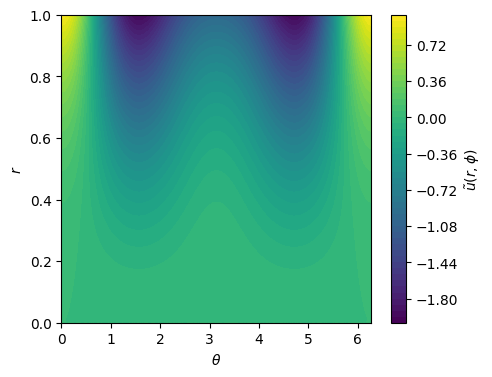

In [5]:
# Potential Fredholm Neural Network class with precalculated integral using parallelized dblquad
# In this Poisson example we only need to pass the integral fundamental*source for (r_o, theta_o) that will be added to the bias term

K = 80
phi_0 = 0.0
phi_n = 2.0 * np.pi
phi_steps = 500
dphi = (phi_n - phi_0) / phi_steps
phi = np.arange(phi_0, phi_n, dphi)

phi_grid_dict = {}
for i in range(0, K + 1):
    phi_grid_dict[f'layer_{i}'] = phi

# Define the grid for prediction (r is needed for the LINN)
r_out = np.linspace(0, 1, 100)
theta_out = phi  #np.linspace(0,2*np.pi, 50)
theta_out_torch = torch.tensor(theta_out, dtype=torch.float32)

t0 = time.time()
# # # Precompute integrals for the output values
precomputed_integrals_source, precomputed_integrals_lambda = parallel_integrate_meshgrid(r_out, theta_out)
precomputed_integrals_BIE = precomputed_integrals_source[-1, :]

# Convert results to tensor and map them to phi grid for quick lookup
precomputed_integral_map = {value: integral for value, integral in zip(theta_out, precomputed_integrals_BIE)}

t1 = time.time()
print(f"Time to precompute integrals: {t1 - t0:.3f} s")

# Model parameters
input_size = len(phi)
output_size = len(theta_out)
km_constant = 0.3

t_2 = time.time()

# Instantiate the Fredholm model
fredholm_model = FredholmNeuralNetwork_Helm(
    phi_grid_dict, kernel, dphi, K, input_size, output_size, km_constant,
    func_fn, precomputed_integral_map)

# Instantiate the LimitInformed model with the precomputed integral for r_out == 1
limit_informed_model = PotentialFredholmNeuralNetwork_Helm(
    fredholm_model=fredholm_model,
    diff_potentials_fn=diff_potentials_limit,
    potential_boundary_fn=potential_boundary,
    precomputed_integral_entire_domain_source = precomputed_integrals_source,
    precomputed_integral_entire_domain_fund = precomputed_integrals_lambda)

# Forward pass
output = limit_informed_model(
    input=theta_out_torch,
    r_out=r_out,
    theta_out=theta_out,
    phi_grid=phi,
    grid_step=dphi)

t_3 = time.time()
print(f"Time to forward pass: {t_3 - t_2:.3f} s")
# Extract data for visualization
data = output.detach().numpy()[:, :, 0]

# Contour plot for visualization in (r, theta) space
R_out, Theta_out = np.meshgrid(r_out, theta_out, indexing='ij')
plt.figure(figsize=(5, 4))
plt.contourf(Theta_out, R_out, data, levels=50, cmap='viridis')
cbar = plt.colorbar()
cbar.set_label(r"$\tilde{u}(r,\phi)$")
plt.xlabel(r"$\theta$")
plt.ylabel(r"$r$")
plt.tick_params(axis='both')
plt.show()


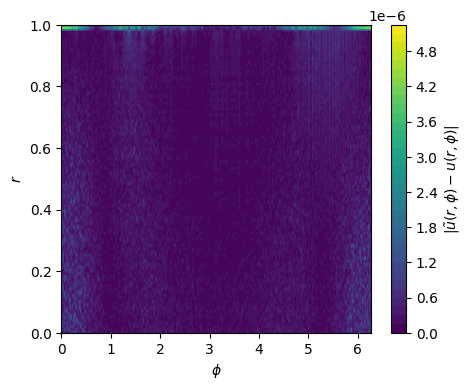

In [6]:
# Calculate and plot absolute error compared to the true solution

# Function to compute the Laplace solution in Cartesian coordinates
def laplace_solution_cartesian(x, y):
    return x**3 - 2*(y**2)  # (1/2) - (x**2 + y**2)/2 #

# Function to compute the Laplace solution in polar coordinates
def laplace_solution_polar(r, theta):
    x = r * np.cos(theta)
    y = r * np.sin(theta)
    return laplace_solution_cartesian(x, y)


# Create the contour plot for the absolute error
difference = np.abs(data - laplace_solution_polar(R_out, Theta_out))
plt.figure(figsize=(5, 4))
plt.contourf(Theta_out, R_out, difference, levels=50, cmap='viridis')
cbar = plt.colorbar()
# cbar.ax.tick_params(labelsize=18)  # Increase font size for colorbar ticks
cbar.set_label(r"$|\tilde{u}(r,\phi) - u(r,\phi)|$")  # Increase font size for colorbar label
plt.xlabel(r"$\phi$")
plt.ylabel(r"$r$")
plt.tick_params(axis='both')  # Increase font size for x and y ticks
plt.show()